# Used Car Price Prediction

[Github](https://github.com/brightblueshimmering/dtsa_5509)

 [Data Source: Kaggle](https://www.kaggle.com/code/nishantrajadhyaksha/cars4u-dataset/input)

Objectives:
- explore and analyze dataset
- Perform Univariate and Bivariate analysis
- Preprocess the data
- Build  models to predict the price.
- Evaluate models with RMSE

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_rows', 300)

In [8]:
df = pd.read_csv('used_cars_data.csv')

In [9]:
df.head(10)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.00000,NaN,1.75000
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.00000,NaN,12.50000
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.00000,8.61 Lakh,4.50000
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.00000,NaN,6.00000
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.00000,NaN,17.74000
5,5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.1 km/kg,814 CC,55.2 bhp,5.00000,NaN,2.35000
6,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.00000,NaN,3.50000
7,7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,8.00000,21 Lakh,17.50000
8,8,Volkswagen Vento Diesel Comfortline,Pune,2013,64430,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.00000,NaN,5.20000
9,9,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.3 kmpl,1248 CC,74 bhp,5.00000,NaN,1.95000


In [10]:
df.shape

(7253, 14)

In [11]:
nans = df.isna().sum()[df.isna().sum() > 0]
print(nans)

Mileage         2
Engine         46
Power          46
Seats          53
New_Price    6247
Price        1234
dtype: int64


Since almost all of 'New Price' is missing I will go ahead and drop it.
I'll drop the missing values in Price as well.

In [12]:
df = df.drop('New_Price',axis=1)
df = df.dropna(subset=['Price'])
df.shape

(6019, 13)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 658.3+ KB


# Preprocessing

Engine, Power, and Mileage are Objects. We can see that there are non-numeric characters in each. 

In [14]:
df[['Engine','Power','Mileage','Fuel_Type']].head(10)

,Engine,Power,Mileage,Fuel_Type
0,998 CC,58.16 bhp,26.6 km/kg,CNG
1,1582 CC,126.2 bhp,19.67 kmpl,Diesel
2,1199 CC,88.7 bhp,18.2 kmpl,Petrol
3,1248 CC,88.76 bhp,20.77 kmpl,Diesel
4,1968 CC,140.8 bhp,15.2 kmpl,Diesel
5,814 CC,55.2 bhp,21.1 km/kg,LPG
6,1461 CC,63.1 bhp,23.08 kmpl,Diesel
7,2755 CC,171.5 bhp,11.36 kmpl,Diesel
8,1598 CC,103.6 bhp,20.54 kmpl,Diesel
9,1248 CC,74 bhp,22.3 kmpl,Diesel


I will remove the text from Engine and Power and convert Mileage to mpg and kilometers_driven to miles_driven.

In [15]:
#removing text from engine and power
df['Engine'] = df['Engine'].astype(str).str.replace(' CC', '', regex=False)
df['Power'] = df['Power'].astype(str).str.replace(' bhp', '', regex=False)

#converting to numbers
df['Engine'] = pd.to_numeric(df['Engine'], errors='coerce')
df['Power'] = pd.to_numeric(df['Power'], errors='coerce')

#coverting km to miles and price to usd
df['miles_driven'] = df['Kilometers_Driven'] * 0.621371
df['price'] = df['Price'] * 1333.33

#changing kmpl to mpg
df_kmpl = df[df['Mileage'].str.contains('kmpl', na=False)]
df_kmpl['mpg'] = df_kmpl['Mileage'].str.replace(' kmpl', '', regex=False).astype(float) * 2.35215

#changing kmkg to mpg
df_kmkg = df[df['Mileage'].str.contains('km/kg', na=False)]
df_kmkg['mpg'] = df_kmkg['Mileage'].str.replace(' km/kg', '', regex=False).astype(float) * 1.568

#adding to mpg col
df.loc[df_kmpl.index, 'mpg'] = df_kmpl['mpg']
df.loc[df_kmkg.index, 'mpg'] = df_kmkg['mpg']

df = df.drop(['Kilometers_Driven', 'Price','Mileage','S.No.'], axis=1)

In [16]:
df.head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,miles_driven,price,mpg
0,Maruti Wagon R LXI CNG,Mumbai,2010,CNG,Manual,First,998.00000,58.16000,5.00000,44738.71200,2333.32750,41.70880
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,Diesel,Manual,First,1582.00000,126.20000,5.00000,25476.21100,16666.62500,46.26679
2,Honda Jazz V,Chennai,2011,Petrol,Manual,First,1199.00000,88.70000,5.00000,28583.06600,5999.98500,42.80913
3,Maruti Ertiga VDI,Chennai,2012,Diesel,Manual,First,1248.00000,88.76000,7.00000,54059.27700,7999.98000,48.85416
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,Diesel,Automatic,Second,1968.00000,140.80000,5.00000,25271.15857,23653.27420,35.75268


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,6019.00000,2013.35820,3.26974,1998.00000,2011.00000,2014.00000,2016.00000,2019.00000
Engine,5983.00000,1621.27645,601.35523,72.00000,1198.00000,1493.00000,1984.00000,5998.00000
Power,5876.00000,113.25305,53.87496,34.20000,75.00000,97.70000,138.10000,560.00000
Seats,5977.00000,5.27874,0.80884,0.00000,5.00000,5.00000,5.00000,10.00000
miles_driven,6019.00000,36498.32610,56711.81237,106.25444,21126.61400,32932.66300,45360.08300,4038911.50000
price,6019.00000,12639.25954,14917.18552,586.66520,4666.65500,7519.98120,13266.63350,213332.80000
mpg,6017.00000,42.44538,10.61015,0.00000,35.51747,42.47983,49.39515,66.80106


We can see that there are 0's in seats and mpg. Miles driven has an oddly high max at 4038911.50 miles.

In [18]:
df['mpg'] = df['mpg'].replace(0, np.nan)
df['Seats'] = df['Seats'].replace(0, np.nan)

In [19]:
df[df['miles_driven'] > 4038911]

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,miles_driven,price,mpg
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,Diesel,Automatic,First,2993.00000,258.00000,5.00000,4038911.50000,86666.45000,37.56384


Imputing with median

In [20]:
df.loc[df['miles_driven'] > 4038911, 'miles_driven'] = df['miles_driven'].median()

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,6019.00000,2013.35820,3.26974,1998.00000,2011.00000,2014.00000,2016.00000,2019.00000
Engine,5983.00000,1621.27645,601.35523,72.00000,1198.00000,1493.00000,1984.00000,5998.00000
Power,5876.00000,113.25305,53.87496,34.20000,75.00000,97.70000,138.10000,560.00000
Seats,5976.00000,5.27962,0.80602,2.00000,5.00000,5.00000,5.00000,10.00000
miles_driven,6019.00000,35832.77056,23534.85146,106.25444,21126.61400,32932.66300,45360.08300,481562.52500
price,6019.00000,12639.25954,14917.18552,586.66520,4666.65500,7519.98120,13266.63350,213332.80000
mpg,5949.00000,42.93055,9.64522,15.05376,35.96437,42.69152,49.63037,66.80106


All of the car brands seem to be the first word of "Name". So here's an attempt to extract those:

In [22]:
#gettting brand name
df['brand'] = df['Name'].str.split(n=1).str[0].str.title()
df['brand'].unique()

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'Land', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'Bmw', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Smart', 'Ambassador', 'Isuzu', 'Force', 'Bentley', 'Lamborghini'],
      dtype=object)

All are recognizable except for Land

In [23]:
df[df['Name'].str.startswith('Land')].head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,miles_driven,price,mpg,brand
13,Land Rover Range Rover 2.2L Pure,Delhi,2014,Diesel,Automatic,First,2179.00000,187.70000,5.00000,44738.71200,35999.91000,29.87230,Land
14,Land Rover Freelander 2 TD4 SE,Pune,2012,Diesel,Automatic,Second,2179.00000,115.00000,5.00000,52816.53500,23333.27500,NaN,Land
191,Land Rover Range Rover 2.2L Dynamic,Coimbatore,2018,Diesel,Automatic,First,2179.00000,187.70000,5.00000,22425.90076,74346.48080,29.87230,Land
311,Land Rover Range Rover HSE Dynamic,Delhi,2017,Diesel,Automatic,First,2179.00000,187.70000,5.00000,27340.32400,58666.52000,29.87230,Land
399,Land Rover Range Rover 2.2L Dynamic,Hyderabad,2012,Diesel,Automatic,First,2179.00000,187.70000,5.00000,34796.77600,39999.90000,29.87230,Land


We can see it's supposed to be Land Rover

In [24]:
df['Name'] = df['Name'].str.replace('Land Rover','LandRover')
df['brand'] = df['brand'].str.replace('Land','LandRover')

In [25]:
df['brand'].unique()

array(['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', 'Toyota',
       'Volkswagen', 'Tata', 'LandRover', 'Mitsubishi', 'Renault',
       'Mercedes-Benz', 'Bmw', 'Mahindra', 'Ford', 'Porsche', 'Datsun',
       'Jaguar', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Fiat', 'Jeep',
       'Smart', 'Ambassador', 'Isuzu', 'Force', 'Bentley', 'Lamborghini'],
      dtype=object)

Next, I will try to get the model be getting the next string before the next space.

In [26]:
df['model'] = df['Name'].str.split(n=1).str[1].str.lower()
#getting next string between following spaces
df['model'] = df['brand'] +'_'+ df['model'].str.split(n=1).str[0]

model_df = pd.DataFrame(df.groupby(['brand', 'model']).size())
model_df.head(300)

0
brand         model                       
Ambassador    Ambassador_classic         1
Audi          Audi_a3                    4
              Audi_a4                   78
              Audi_a6                   49
              Audi_a7                    3
              Audi_a8                    2
              Audi_q3                   27
              Audi_q5                   30
              Audi_q7                   38
              Audi_rs5                   2
              Audi_tt                    3
Bentley       Bentley_continental        1
Bmw           Bmw_1                      3
              Bmw_3                     98
              Bmw_5                     68
              Bmw_6                      7
              Bmw_7                     13
              Bmw_x1                    32
              Bmw_x3                    14
              Bmw_x5                    24
              Bmw_x6                     6
              Bmw_z4                     2
Chevrolet     Chevrolet_aveo            14
              Chevrolet_beat            46
              Chevrolet_captiva          2
              Chevrolet_cruze           18
              Chevrolet_enjoy            9
              Chevrolet_optra           12
              Chevrolet_sail             8
              Chevrolet_spark           10
              Chevrolet_tavera           2
Datsun        Datsun_go                  6
              Datsun_redi                1
              Datsun_redi-go             6
Fiat          Fiat_avventura             4
              Fiat_grande                5
              Fiat_linea                12
              Fiat_petra                 1
              Fiat_punto                 5
              Fiat_siena                 1
Force         Force_one                  3
Ford          Ford_aspire                4
              Ford_classic               1
              Ford_ecosport             95
              Ford_endeavour            39
              Ford_fiesta               40
              Ford_figo                101
              Ford_freestyle             3
              Ford_fusion                1
              Ford_ikon                 15
              Ford_mustang               1
Honda         Honda_accord              26
              Honda_amaze              106
              Honda_br-v                 3
              Honda_brio                60
              Honda_brv                  5
              Honda_city               270
              Honda_civic               32
              Honda_cr-v                27
              Honda_jazz                58
              Honda_mobilio             16
              Honda_wr-v                 1
              Honda_wrv                  4
Hyundai       Hyundai_accent            18
              Hyundai_creta             93
              Hyundai_elantra           22
              Hyundai_elite             14
              Hyundai_eon               61
              Hyundai_getz              10
              Hyundai_grand            152
              Hyundai_i10              156
              Hyundai_i20              247
              Hyundai_santa             17
              Hyundai_santro            78
              Hyundai_sonata             6
              Hyundai_tucson             4
              Hyundai_verna            170
              Hyundai_xcent             59
Isuzu         Isuzu_d-max                2
              Isuzu_mux                  1
Jaguar        Jaguar_f                   1
              Jaguar_xe                  3
              Jaguar_xf                 30
              Jaguar_xj                  6
Jeep          Jeep_compass              15
Lamborghini   Lamborghini_gallardo       1
LandRover     LandRover_discovery       12
              LandRover_freelander      17
              LandRover_range           31
Mahindra      Mahindra_bolero           15
              Mahindra_e                 1
              Mahindra_jeep              2

Looks like most are valid. I wont use the model or brand as features, but I will use them to impute missing values.

In [27]:
nans = df.isna().sum()[df.isna().sum() > 0]
print(nans)

Engine     36
Power     143
Seats      43
mpg        70
dtype: int64


We can see there are a decent amount of nans in Power, and some in Engine, Seats and Mpg. I will try to impute by model first and then by make if there isnt a median by model.

In [28]:
nan_cols = ['Engine', 'Power', 'Seats', 'mpg']

#medians by model & make
model_medians = df.groupby('model')[nan_cols].transform('median')
make_medians = df.groupby('brand')[nan_cols].transform('median')

#filling nans by model then make
df[nan_cols] = df[nan_cols].fillna(model_medians)
df[nan_cols] = df[nan_cols].fillna(make_medians)

We are left with 1 missing Power and mpg.

In [29]:
nans = df.isna().sum()[df.isna().sum() > 0]
print(nans)

Power    1
mpg      1
dtype: int64


In [30]:
df[df['Power'].isna()]

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,miles_driven,price,mpg,brand,model
915,Smart Fortwo CDI AT,Pune,2008,Diesel,Automatic,Second,799.00000,NaN,2.00000,64001.21300,3999.99000,NaN,Smart,Smart_fortwo


Both appear to be this Smart Car. I googled the values and add them to the df.

In [31]:
df.loc[915,'Power'] = 53
df.loc[915,'mpg'] = 85

In [32]:
df.isna().sum().sum()

np.int64(0)

### EDA

In [33]:
df = df.drop(['Name','model'],axis=1)

In [34]:
num_cols = ['Year','price','miles_driven','Engine','Power','Seats','mpg']
cat_cols = ['Location','Fuel_Type','Transmission','Owner_Type','brand']

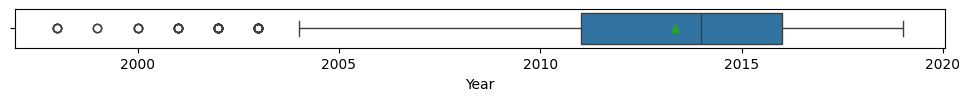

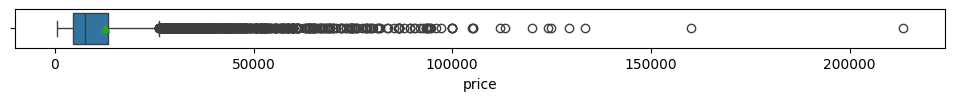

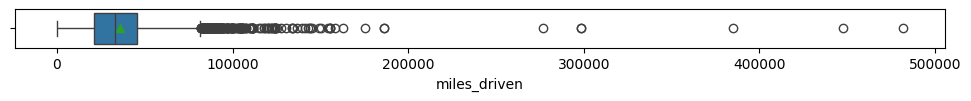

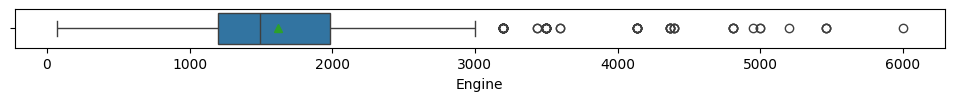

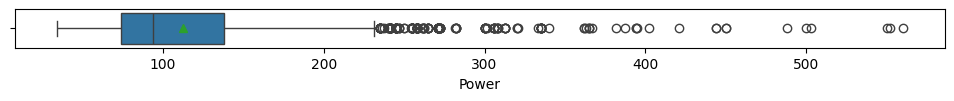

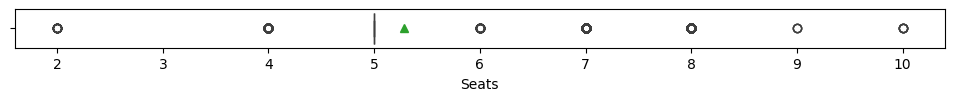

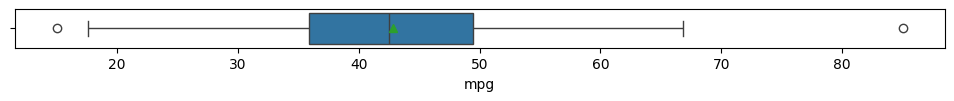

In [35]:
for col in num_cols:
    plt.figure(figsize=(12,.5))
    sns.boxplot(data=df, x=col,showmeans=True)
    plt.show()

In [36]:
df['price'].mean()

np.float64(12639.25953540455)

- Year : Fairly left skewed, with the average around 2013
- miles : Right skewed, with average around 60,000km.
- mpg : Little skew, around 43 on avg.
- Engine : Fairly right skewed, with average around 1600cc
- Power : Right skewed, with average around 120 bhp
- Price : Right skewed, with average around 12000

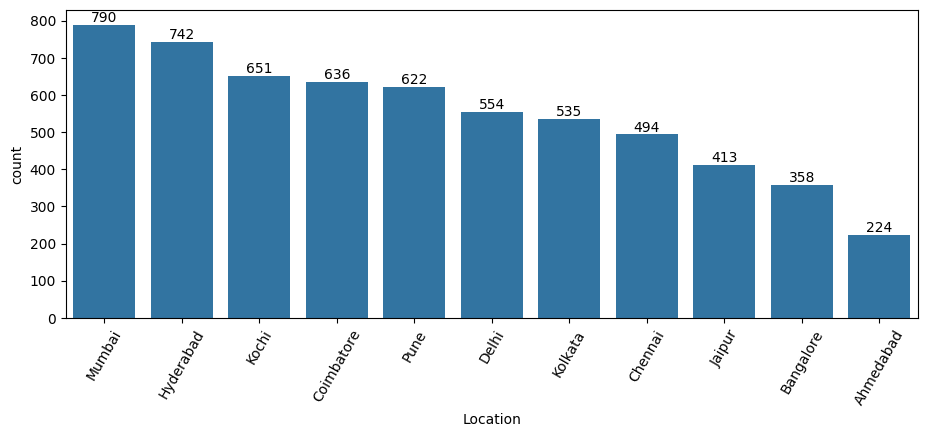

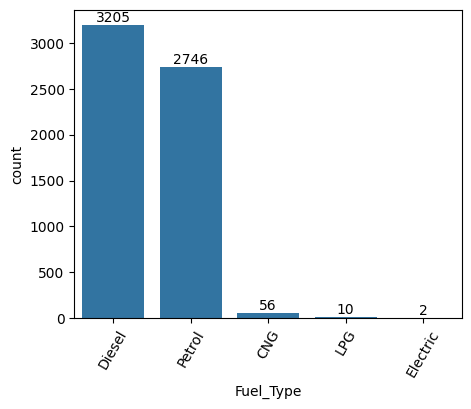

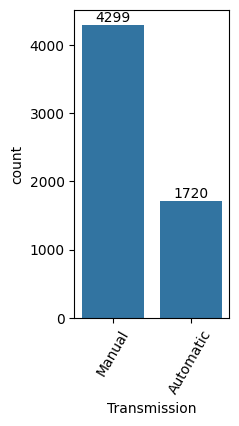

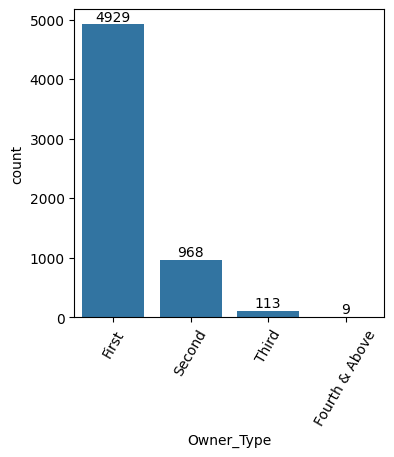

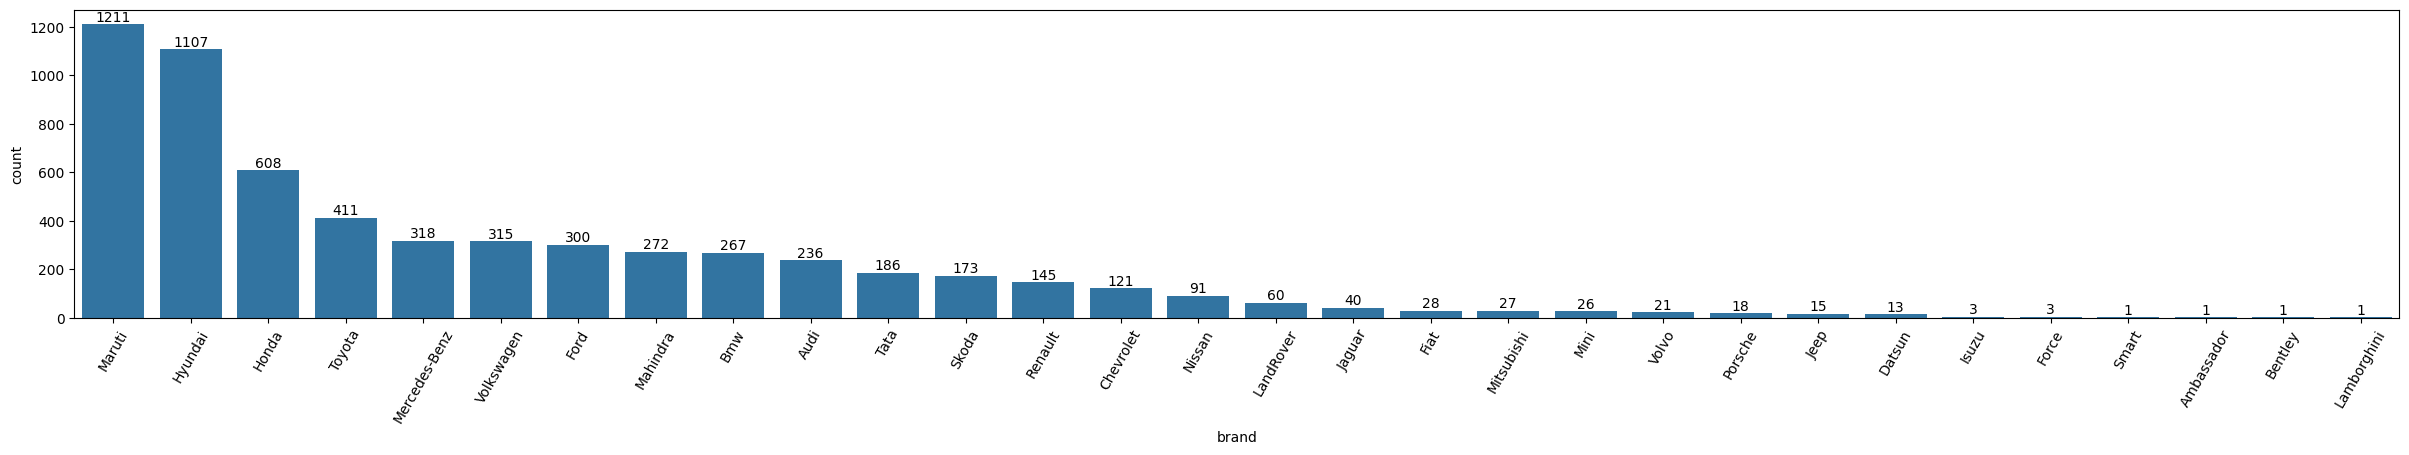

In [37]:
for col in cat_cols:
  plt.figure(figsize=(df[col].nunique(),4))
  ax = sns.countplot(x=col, data = df, order = df[col].value_counts().index)
  plt.xticks(rotation=60)
  ax.bar_label(ax.containers[0], label_type='edge');

- Location: Most cars are located in Mumbai, the least are in Amhedabad.
- Fuel Type: Most cars are either Petrol and Diesel
- Transmission: There are more manual cars than automatic
- Owner Type: Most cars have only had one owner, followed by two owner's.
- Seats: Most have 5 seats, followed by 7.
- Brand: Most Cars are from Maruti

Bivariate

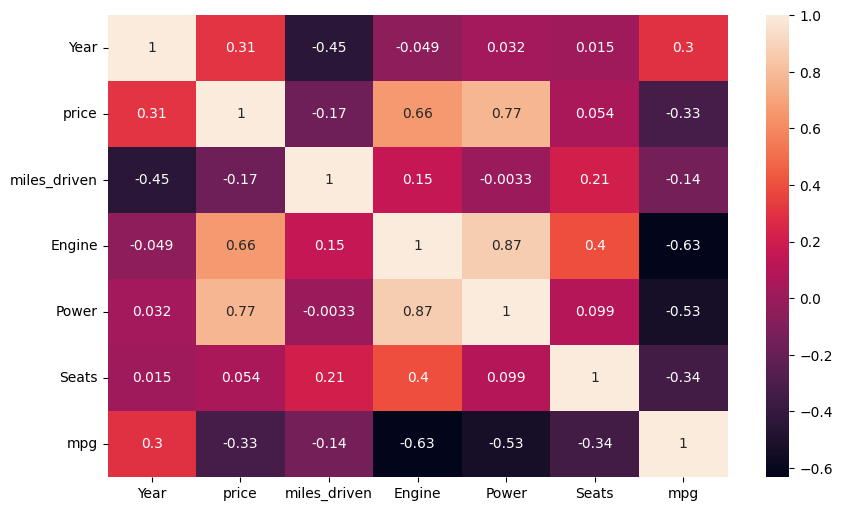

In [38]:
num_df = df[num_cols]
plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(),annot=True);

In [39]:
df[num_cols].corr()['price'].sort_values(ascending=False)

price           1.00000
Power           0.77385
Engine          0.65896
Year            0.30533
Seats           0.05368
miles_driven   -0.16806
mpg            -0.32850
Name: price, dtype: float64

Price is most highly correlated with Power followed by Engine. Power and Engine are hihly correlalted and both are negatively correlaed with mpg.

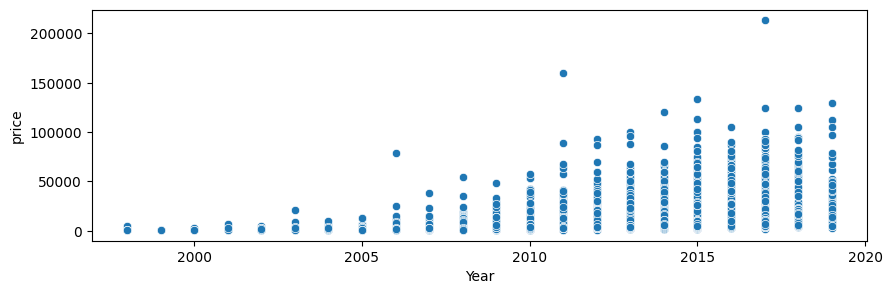

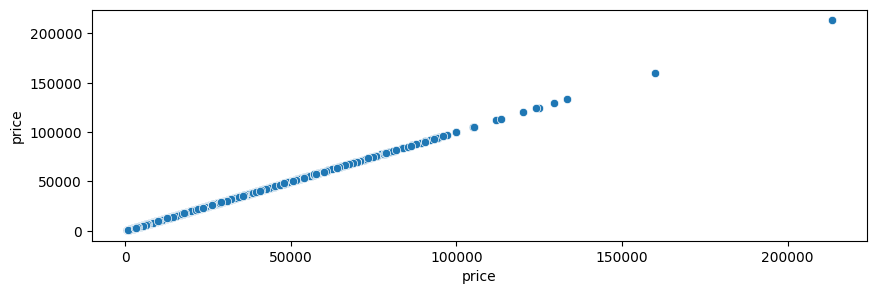

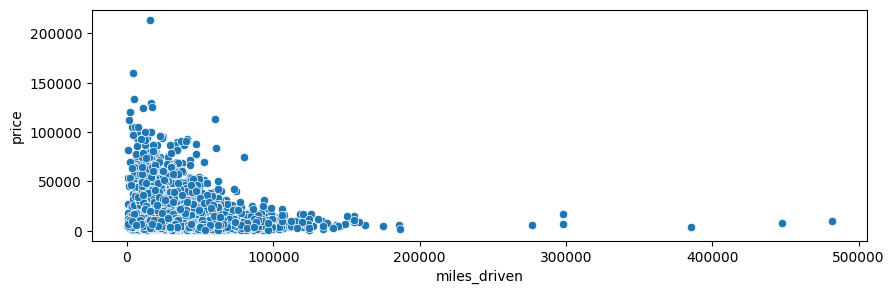

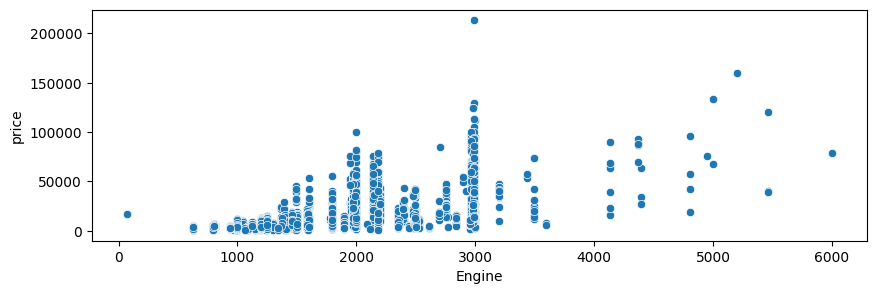

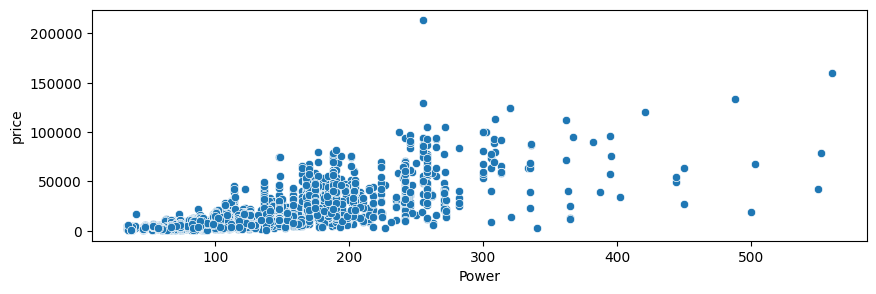

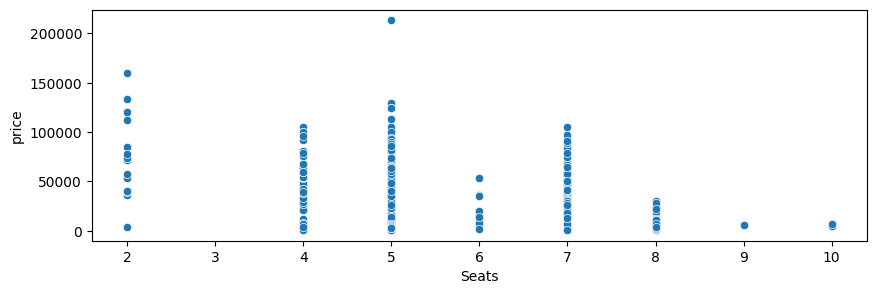

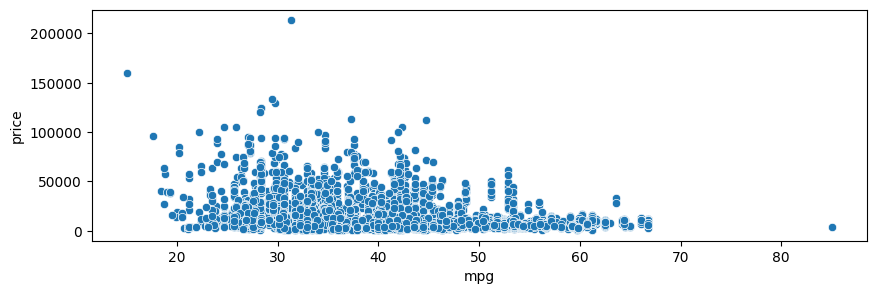

In [40]:
for col in num_cols:
  plt.figure(figsize=(10,3))
  sns.scatterplot(data=df,y='price', x=col)
  plt.show()

Here we can better see see some of the correlations with price. Newer cars with less mileage have higher max values compared to older cars that have been driven more.

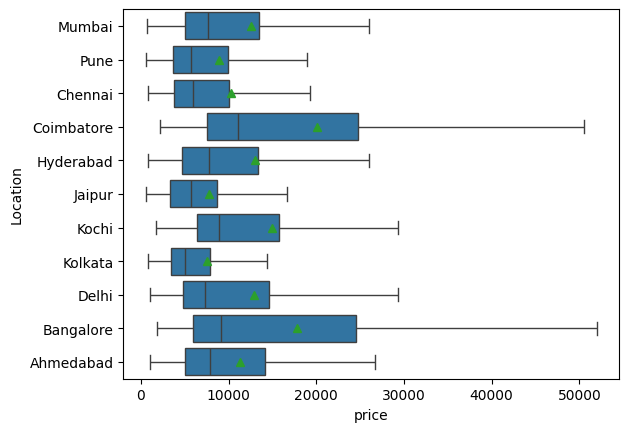

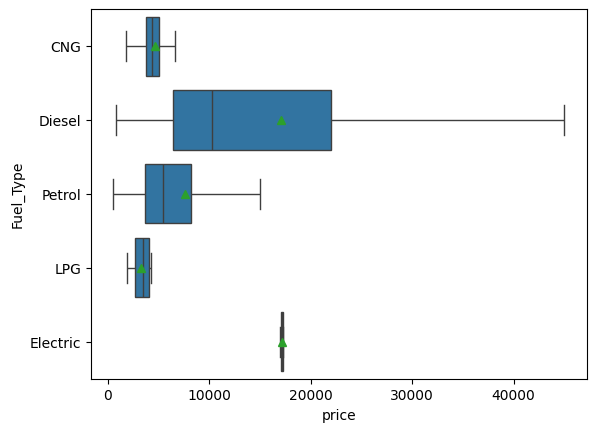

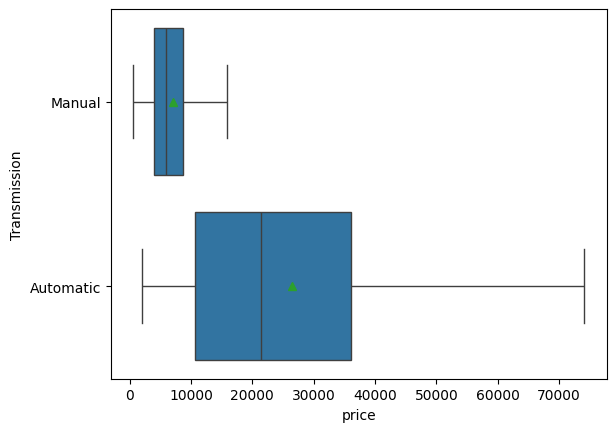

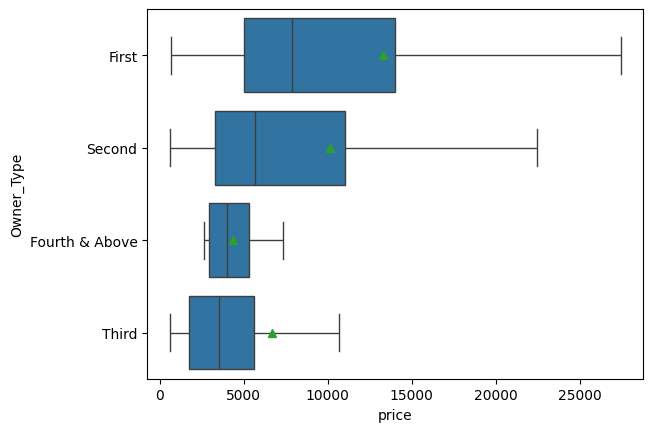

In [41]:
cat_cols = ['Location','Fuel_Type','Transmission','Owner_Type']
for col in cat_cols:
    sns.boxplot(data=df,x='price', y=col,showmeans=True,showfliers=False)
    plt.show()

- Price by Location: Bangalore and Coimbatore have the highest average and median used cars by price, while Kolkata and Jaipur have the lowest.
- Price by Fuel Type: Diesel cars have the highest value, CNG and LPG are the least valuable.
- Price by Transmission: Automatic cars have sold at higher prices.
- Price by Owner Type: Cars with less previous owners are more valuable.
- Price by Seats: 2-seat cars are most valuable followed by 4 seat cars.

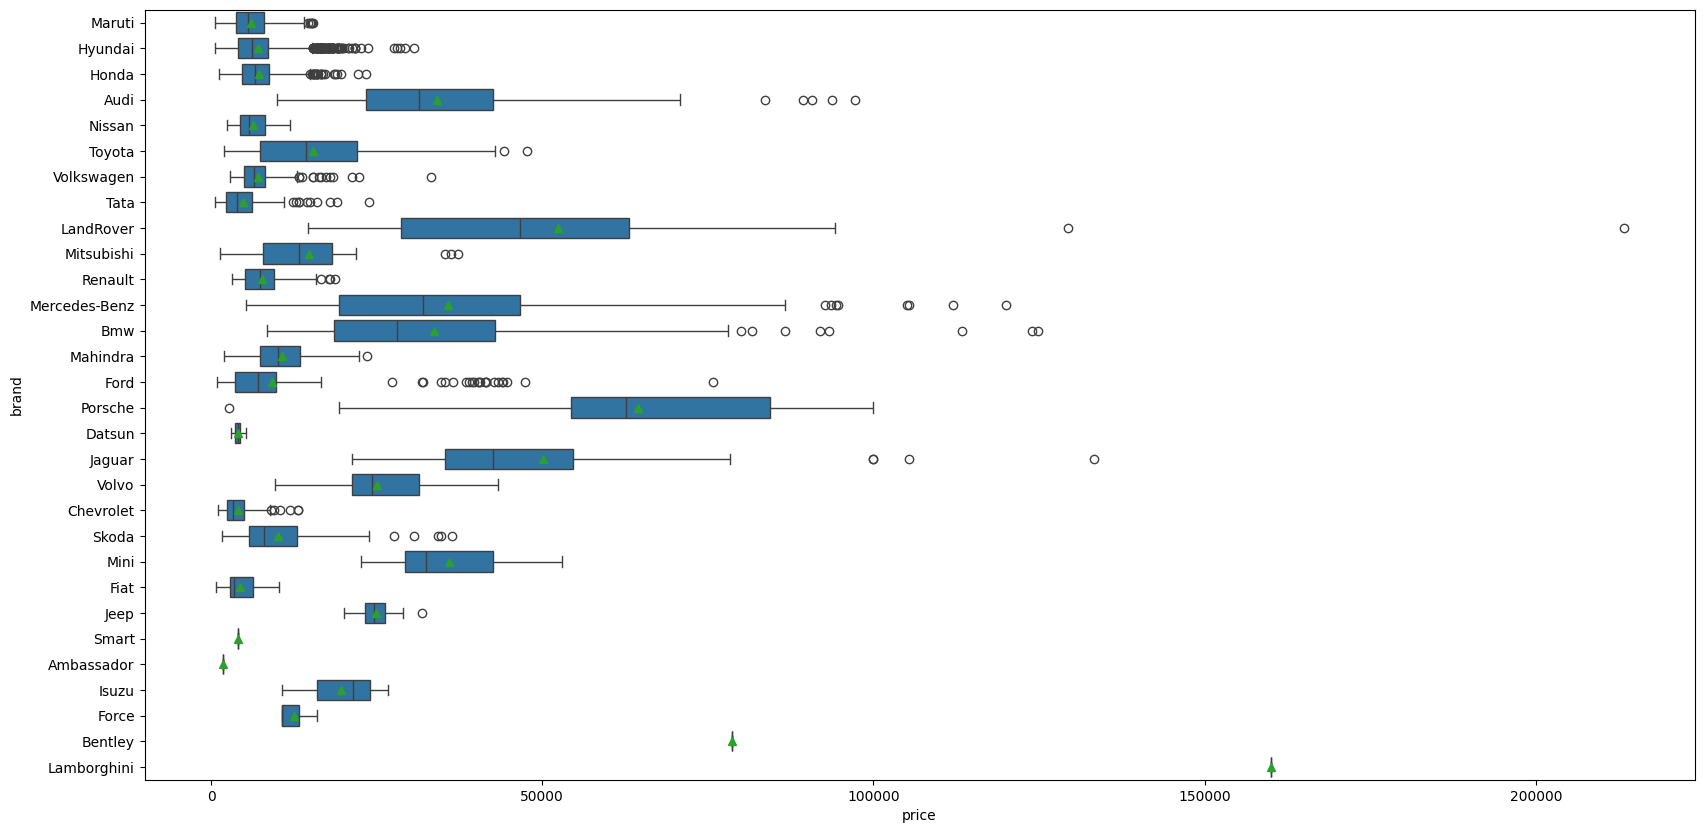

In [42]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='price', y='brand', showmeans=True,showfliers=True);

Above we can see price by brand. There are a outliers that we will look at below:

### **Outliers**

In [43]:
df[(df['price']>200000)&(df['brand']=='LandRover')]

,Location,Year,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,miles_driven,price,mpg,brand
4079,Hyderabad,2017,Diesel,Automatic,First,2993.00000,255.00000,5.00000,15534.27500,213332.80000,31.35416,LandRover


In [44]:
df[(df['price'] < 5000) & (df['brand'] =='Porsche')]

,Location,Year,Fuel_Type,Transmission,Owner_Type,Engine,Power,Seats,miles_driven,price,mpg,brand
3132,Kochi,2019,Petrol,Automatic,First,2995.00000,340.00000,5.00000,8884.36256,2693.32660,31.35416,Porsche


To fix these outliers, I created a function to impute the outliers with a given quantile by group. So here I will do it by brand.

In [45]:
def impute_by_group(df, group_col, col,lower_quantile,upper_quantile):
    grouped = df.groupby(group_col,group_keys=True)

    def impute_group(group):
        lower_limit = group[col].quantile(lower_quantile)
        upper_limit = group[col].quantile(upper_quantile)
        group[col] = group[col].apply(lambda x: lower_limit if x < lower_limit else (upper_limit if x > upper_limit else x))
        return group

    #applying
    df = grouped.apply(impute_group)
    return df.reset_index(drop=True)

In [46]:
df = impute_by_group(df, 'brand', 'price',lower_quantile=.03,upper_quantile=.97)

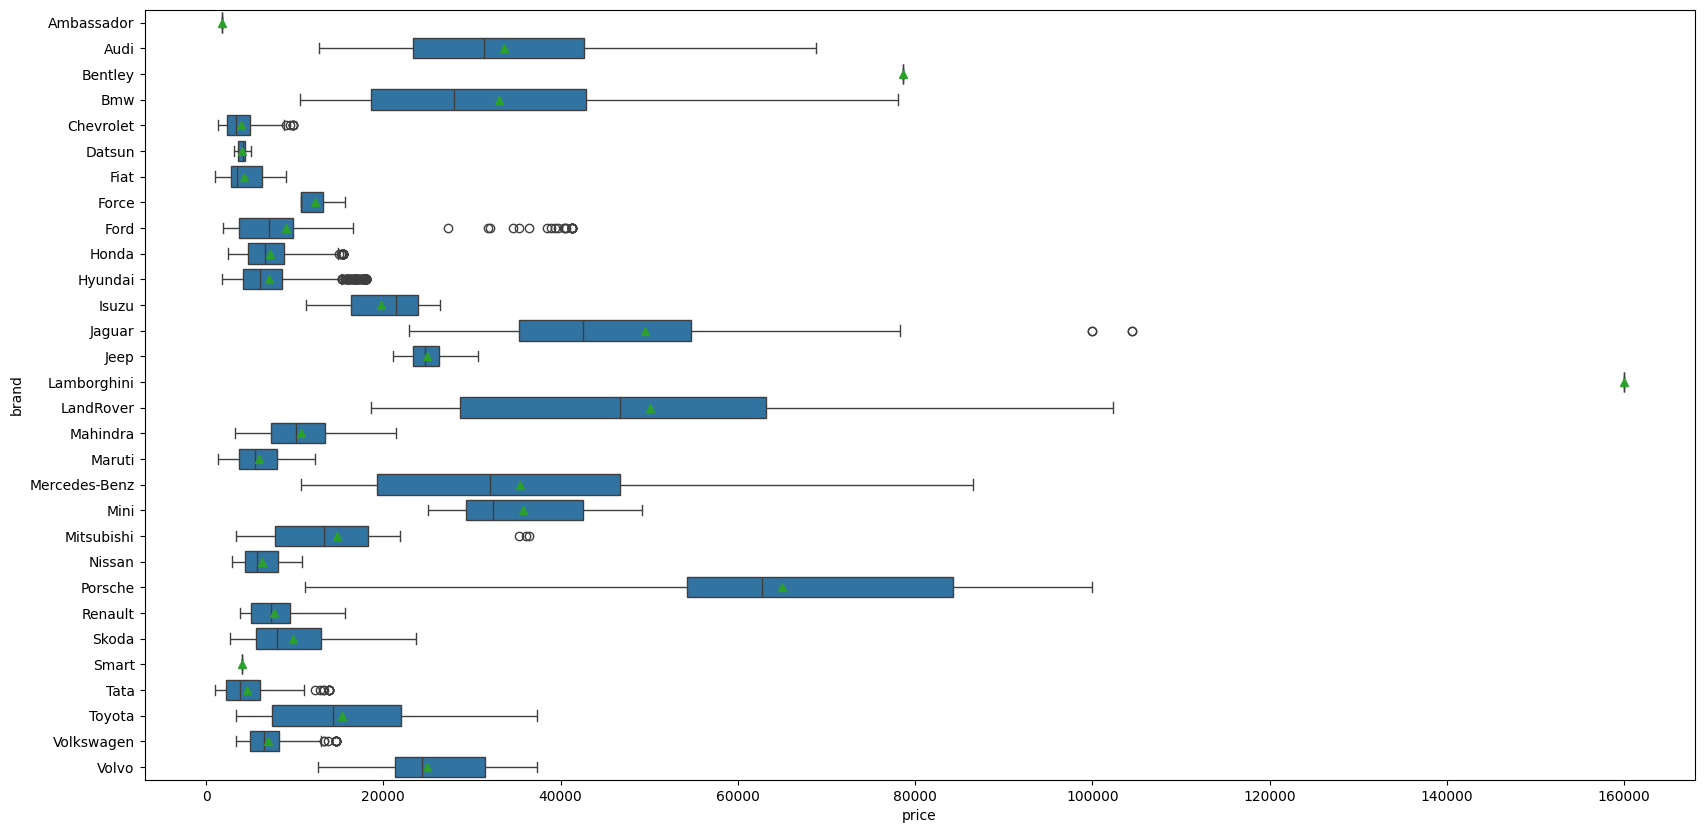

In [47]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,x='price', y='brand', showmeans=True,showfliers=True);

There are still outliers, but the extreme points have been moved closer to the median.

Now we will bin the cars into a type based off the car brand.

In [48]:
#creating dictionary with keys as types and brands as values
car_types = {
    'Luxury' : ['Bentley', 'Lamborghini'],
    'High-End': ['Audi', 'Mercedes-Benz', 'Bmw', 'Jaguar', 'Porsche', 'LandRover'],
    'Mid-Level': ['Honda', 'Toyota', 'Volkswagen', 'Mitsubishi', 'Renault', 'Volvo', 'Chevrolet', 'Skoda', 'Mini', 'Jeep', 'Isuzu','Ford'],
    'Economy': ['Maruti', 'Hyundai', 'Nissan', 'Tata', 'Mahindra', 'Datsun', 'Smart', 'Ambassador', 'Force', 'Fiat']}

# adding class column to df
df['type'] = df['brand'].apply(lambda x: next((brand for brand, models in car_types.items() if x in models), 'Unknown'))

In [49]:
df = df.drop('brand',axis=1)

Now I will look at the skewed columns and log transform them. 

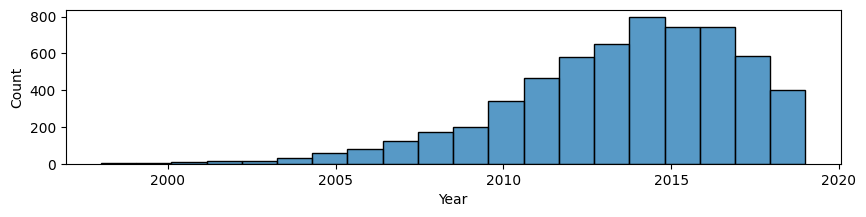

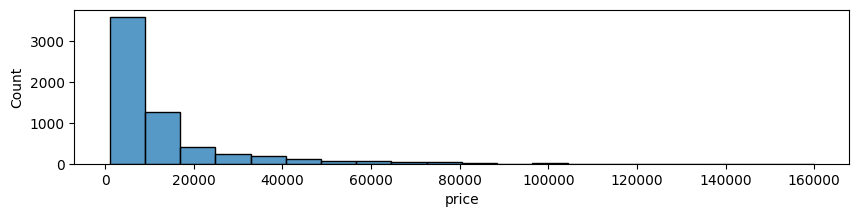

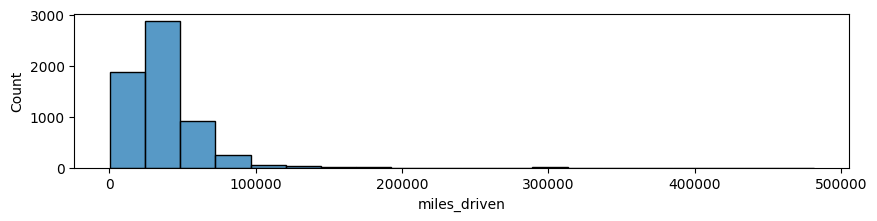

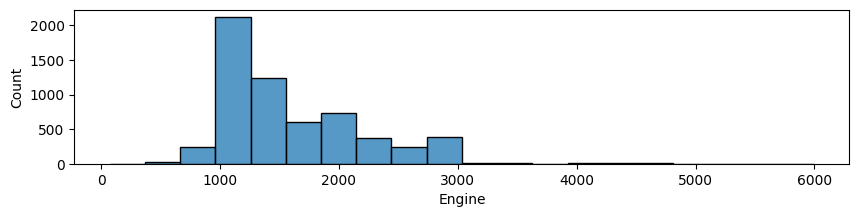

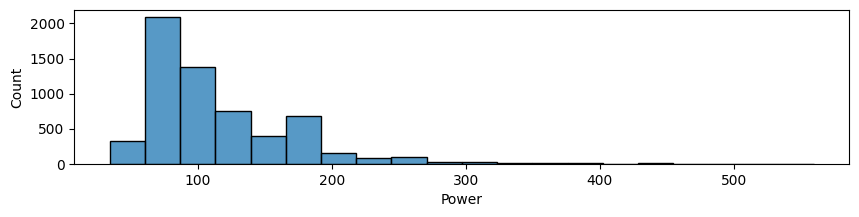

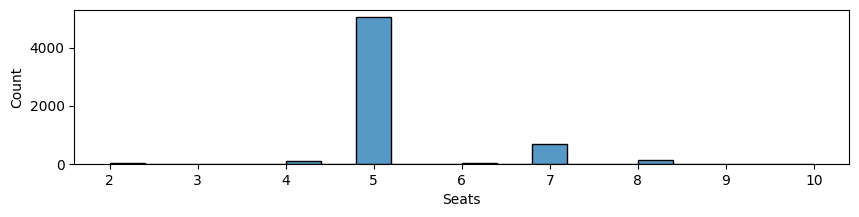

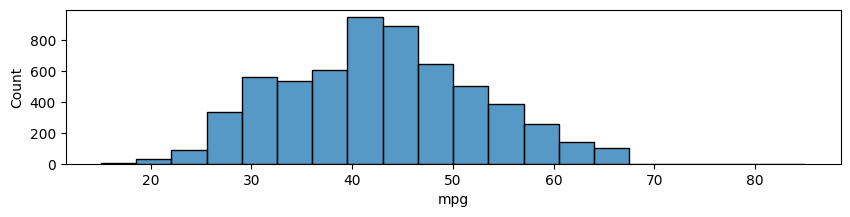

In [50]:
for col in num_cols:
    plt.figure(figsize=(10,2))
    sns.histplot(data=df, x=col,bins=20)
    plt.show()

Engine, Power, miles_driven and price are skewed so I will log transform them.

In [51]:
#log transform

df['engine_log'] = np.log(df['Engine'])
df['power_log'] = np.log(df['Power'])
df['miles_driven_log'] = np.log(df['miles_driven'])
df['price_log'] = np.log(df['price'])

df = df.drop(['Engine','Power','miles_driven', 'price'],axis=1)

In [52]:
df.head()

,Location,Year,Fuel_Type,Transmission,Owner_Type,Seats,mpg,type,engine_log,power_log,miles_driven_log,price_log
0,Chennai,2003,Diesel,Manual,Third,5.00000,30.10752,Economy,7.30586,3.56953,10.81395,7.49554
1,Coimbatore,2013,Diesel,Automatic,Second,5.00000,35.75268,High-End,7.58477,4.94734,10.13742,10.07126
2,Mumbai,2015,Petrol,Automatic,First,5.00000,31.82459,High-End,7.59287,5.17621,10.45701,10.35244
3,Kolkata,2010,Diesel,Automatic,First,5.00000,29.16666,High-End,7.90027,5.19018,9.98728,9.63778
4,Kochi,2015,Diesel,Automatic,First,5.00000,40.24529,High-End,7.58477,5.16095,9.04552,10.26023


In [53]:
df.columns

Index(['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Seats',
       'mpg', 'type', 'engine_log', 'power_log', 'miles_driven_log',
       'price_log'],
      dtype='object')

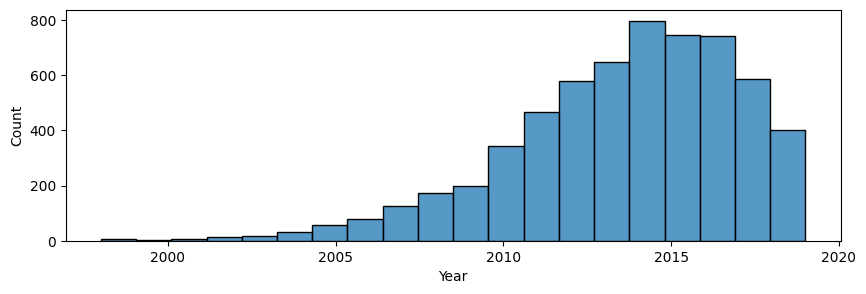

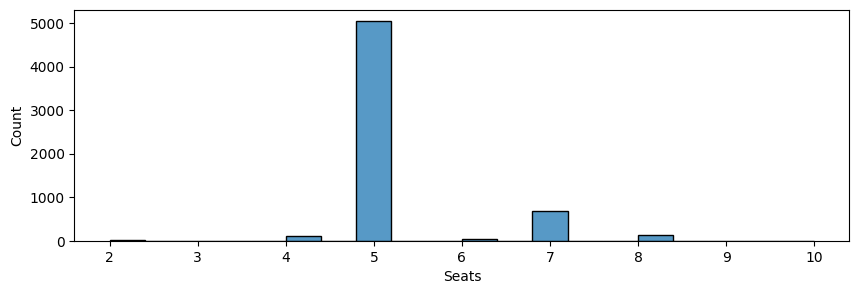

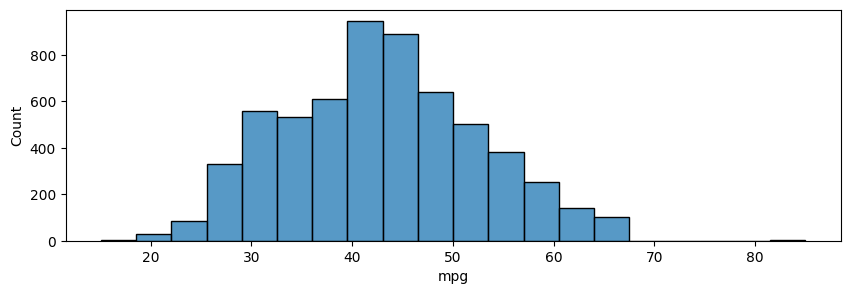

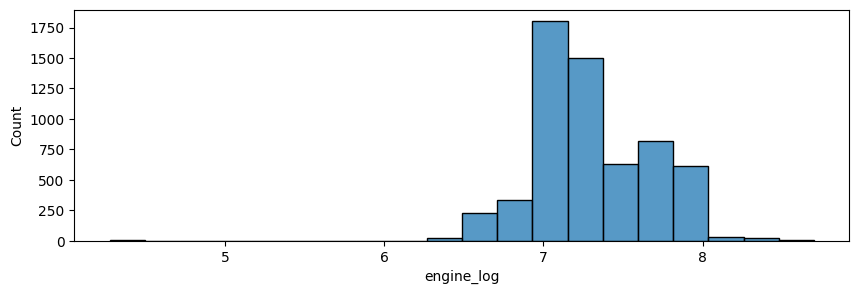

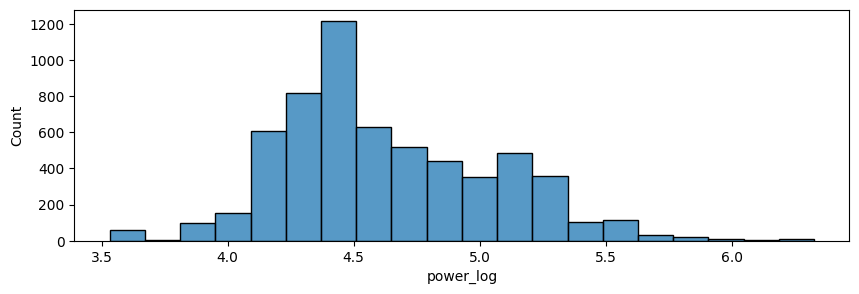

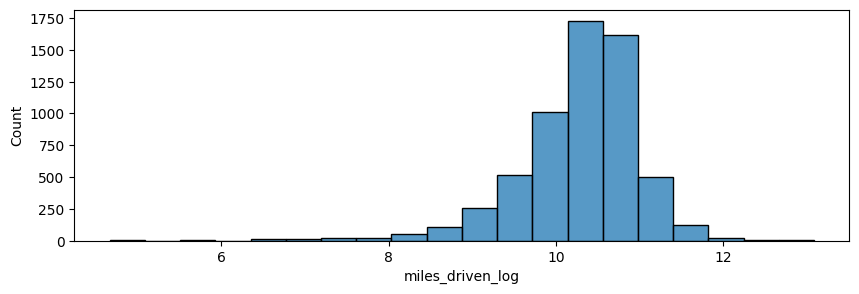

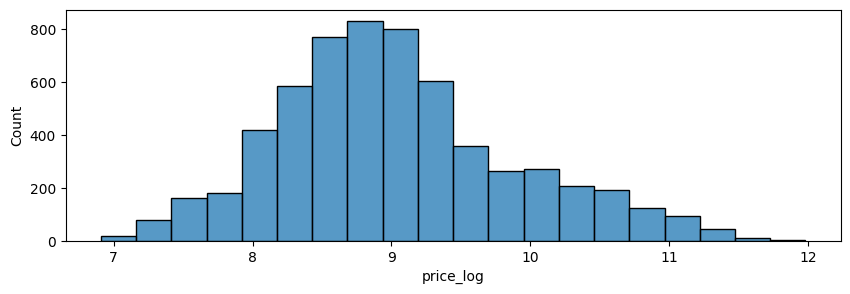

In [54]:
num_cols = ['Year', 'Seats','mpg', 'engine_log', 'power_log', 'miles_driven_log','price_log']

for col in num_cols:
    plt.figure(figsize=(10,3))
    sns.histplot(data=df, x=col,bins=20)
    plt.show()

## Creating Models

In [55]:
 #converting object data type to category data type
df["Fuel_Type"] = df["Fuel_Type"].astype("category")
df["Transmission"] = df["Transmission"].astype("category")
df["Owner_Type"] = df["Owner_Type"].astype("category")
df["Location"] = df["Location"].astype("category")

In [56]:
#splitting data
y = df["price_log"]
X = df.drop("price_log", axis=1)
#encoding
X = pd.get_dummies(X,dtype=int, drop_first=True)

#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3611, 27)
(1204, 27)
(1204, 27)


Creating a function to check variance inflation factor.

In [57]:
#vif
def vif(x):

    x = x.select_dtypes(include=[float, int])
    vif_df = pd.DataFrame()
    x = sm.add_constant(x)

    vif_df["Feature"] = x.columns

    vif_df["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return vif_df

vif(X_train)

,Feature,VIF
0,const,842404.94592
1,Year,2.16107
2,Seats,1.92803
3,mpg,3.74766
4,engine_log,12.19082
5,power_log,9.16840
6,miles_driven_log,1.77268
7,Location_Bangalore,2.44159
8,Location_Chennai,3.08306
9,Location_Coimbatore,3.47874


engine_log and power_log are over 10. I'll drop engine_log.

In [58]:
#dropping engine_log
y = df["price_log"]
X = df.drop(["price_log","engine_log"], axis=1)
#encoding
X = pd.get_dummies(X,dtype=int, drop_first=True)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3611, 26)
(1204, 26)
(1204, 26)


In [59]:
vif(X_train)

,Feature,VIF
0,const,831164.09776
1,Year,2.15248
2,Seats,1.79212
3,mpg,2.99019
4,power_log,3.63179
5,miles_driven_log,1.77266
6,Location_Bangalore,2.44115
7,Location_Chennai,3.08216
8,Location_Coimbatore,3.47836
9,Location_Delhi,3.17719


Now power_log is under 10.

Scaling 

In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)
X_val = scaler.transform(X_val)

Function to create a df of rmse's

In [61]:
def calc_rmse(models, X_train, y_train, X_test, y_test):
    rmse_results = []
    for model in models:

        #training
        train_preds = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        #test
        test_preds = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        
        rmse_results.append({"Model": model.__class__.__name__,"Train_RMSE": train_rmse, "Val/Test_RMSE": test_rmse})
        
    rmse_df = pd.DataFrame(rmse_results)
    return rmse_df


Creating and fitting a decision tree, random forest, and xgboost

In [62]:
#decision tree
tree_model = DecisionTreeRegressor(random_state = 1)
tree_model.fit(X_train, y_train)

#random forest
forest_model = RandomForestRegressor(n_estimators = 100, random_state = 1)
forest_model.fit(X_train, y_train)

#xgboost
boost_model = XGBRegressor(random_state = 1)
boost_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

Function to plot feature importances given a model

In [63]:
def feat_imp_plot(model,name,top_n=15):
  features = list(X.columns)
  importances = model.feature_importances_

  df = pd.DataFrame({'Feature': features, 'Importance': importances})
  df = df.sort_values(by='Importance', ascending=False)

  plt.figure(figsize=(18, 4))
  ax = sns.barplot(x='Importance', y='Feature', data=df.head(top_n))
  ax.bar_label(ax.containers[0], label_type='edge',fmt='%.3f');
  plt.title(f'{name}');

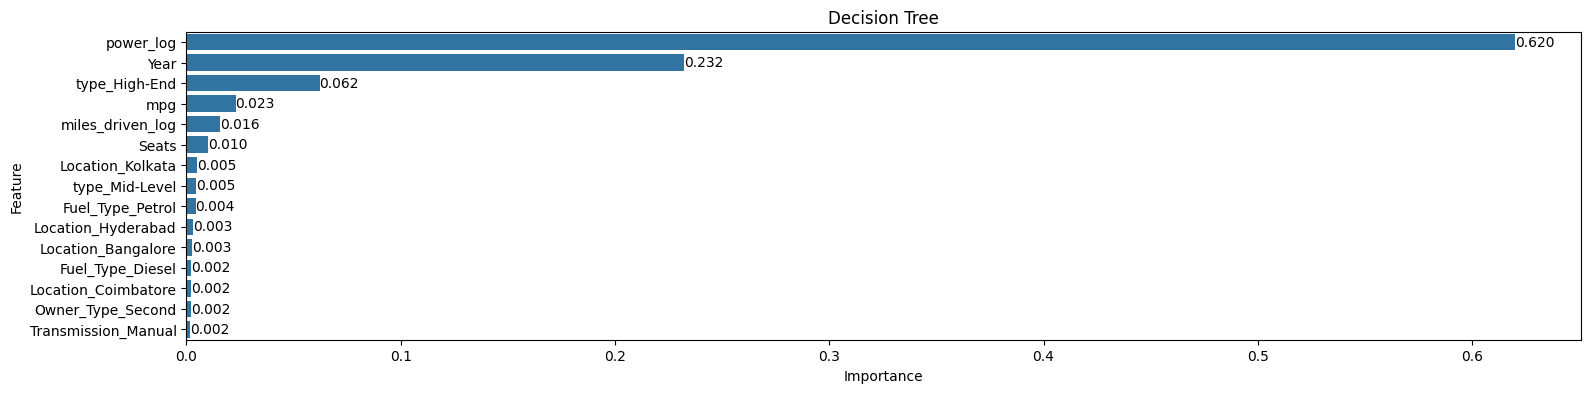

In [64]:
feat_imp_plot(tree_model,'Decision Tree')

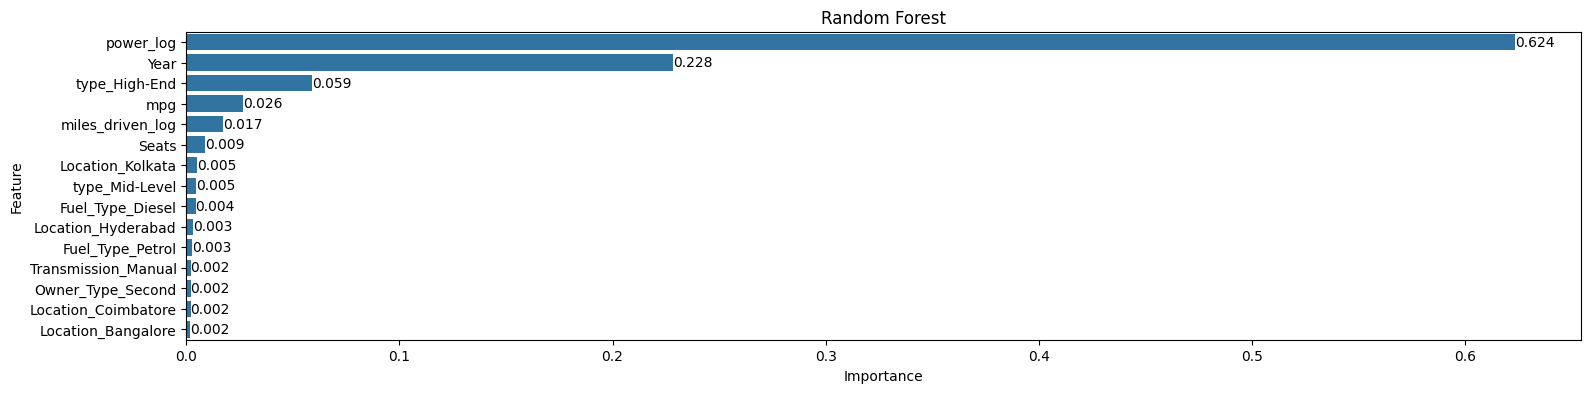

In [65]:
feat_imp_plot(forest_model,'Random Forest')

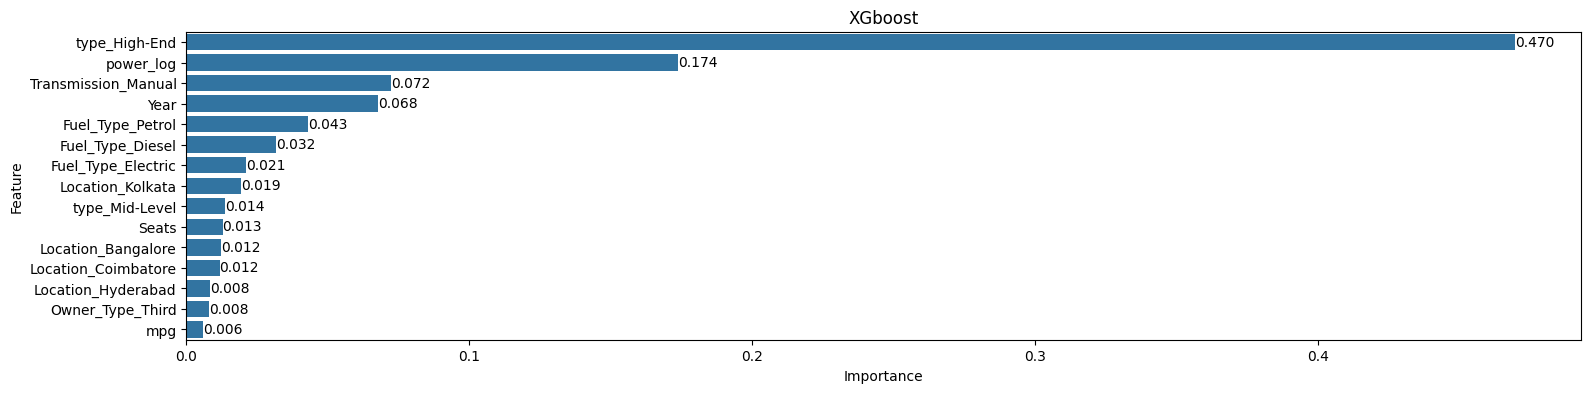

In [66]:
feat_imp_plot(boost_model,'XGboost')

Both the decision tree and random forest have power_log, year, and type_high-end as their top 3. The xgboost has type_high-end, power_log, and Transmission_Manual in the top 3. 

In [67]:
models = [tree_model,forest_model,boost_model]
calc_rmse(models, X_train, y_train, X_val, y_val)

,Model,Train_RMSE,Val/Test_RMSE
0,DecisionTreeRegressor,0.00191,0.31861
1,RandomForestRegressor,0.07834,0.22214
2,XGBRegressor,0.07374,0.21294


The decision tree has quite a large disparity between the test and validation rmse. The random forest and xgboots are closer so we will tune them with gridsearch.

In [68]:
tuned_forest = RandomForestRegressor(random_state=1)

#param grid
forest_params = {"n_estimators": [90, 100], "max_depth": [5, 7, 9, None],"max_features": [0.6, 0.8, 1]}

#gridsearch
forest_grid = GridSearchCV(tuned_forest, forest_params, scoring='neg_mean_squared_error', cv=10)

forest = forest_grid.fit(X_train, y_train)

tuned_forest = forest.best_estimator_

print(f"Best RandomForest parameters: {forest_grid.best_estimator_}")

Best RandomForest parameters: RandomForestRegressor(max_features=0.6, random_state=1)


In [69]:
tuned_boost = XGBRegressor(random_state=1)

#param grid
boost_params = {'n_estimators': [50, 100, 200],'learning_rate': [0.01, 0.1, 0.2],'max_depth': [3, 6, 9],'reg_lambda': [1, 5, 10],'reg_alpha': [0, 0.5, 1]}

#gridsearch
boost_grid = GridSearchCV(tuned_boost, boost_params, scoring='neg_mean_squared_error', cv=10)

boost = boost_grid.fit(X_train, y_train)

tuned_boost = boost.best_estimator_

print(f"Best XGBRegressor parameters: {boost.best_estimator_}")

Best XGBRegressor parameters: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)


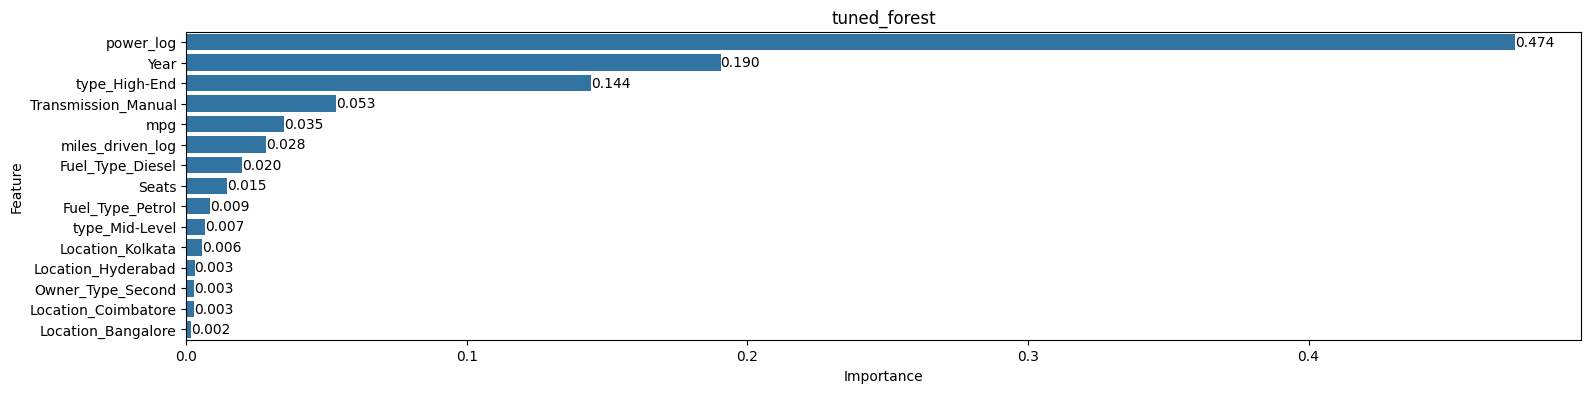

In [70]:
feat_imp_plot(tuned_forest,'tuned_forest')

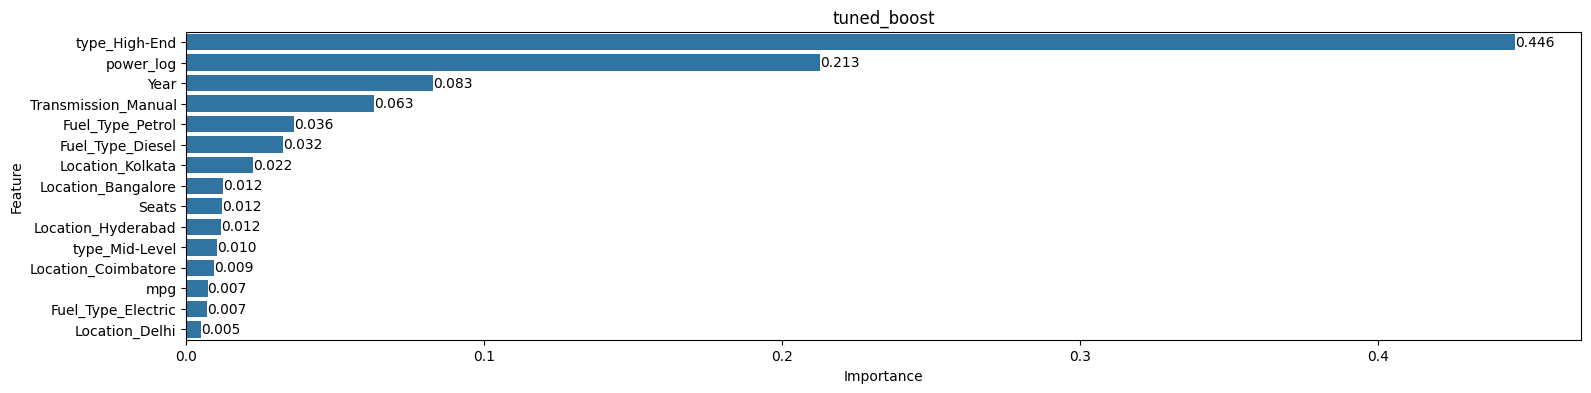

In [71]:
feat_imp_plot(tuned_boost,'tuned_boost')

We can see that the values of the importances have changed but the the orders haven't changed much.

In [72]:
models = [tuned_forest,tuned_boost]

test_df = calc_rmse(models, X_train, y_train, X_test, y_test)
all_df = calc_rmse(models, X_train, y_train, X_val, y_val)
all_df['Test_RMSE '] = test_df.iloc[:, -1]
all_df = all_df.rename(columns={'Test_RMSE':'Validation_RMSE'})
all_df

,Model,Train_RMSE,Val/Test_RMSE,Test_RMSE
0,RandomForestRegressor,0.07492,0.20770,0.22193
1,XGBRegressor,0.08322,0.20087,0.20424


Here we can see that there is still a disparity, but the model seems to perform consistently between the test and validation sets. Overall, the models find that horsepower, whether or not a car brand is 'high end', and how old a car is are some of the main features that determine price. The models are decent, but I believe that with more tuning and possibly more data, error could reduced lower. There are potential things like car condition of vehicle, previous accidents, maintenance history etc. that can influence price and be beneficial to a predicting cost. 